In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import pickle

In [2]:
skin_df = pd.read_csv('HAM10000_metadata.csv')

In [3]:
SIZE=32

In [4]:
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id     dx    dx_type   age     sex  \
4011  HAM_0003257  ISIC_0024559     nv  follow_up  75.0    male   
6108  HAM_0005138  ISIC_0027207     nv  follow_up  45.0  female   
3223  HAM_0007294  ISIC_0025749     nv  follow_up  55.0    male   
871   HAM_0003010  ISIC_0029924    bkl  consensus  55.0  female   
585   HAM_0005199  ISIC_0024982    bkl      histo  55.0    male   
9767  HAM_0006135  ISIC_0031044  akiec      histo  60.0    male   
3703  HAM_0004537  ISIC_0026361     nv  follow_up  60.0    male   
9262  HAM_0005531  ISIC_0024577     nv  consensus  45.0    male   
299   HAM_0006325  ISIC_0027739    bkl      histo  50.0    male   
7438  HAM_0004550  ISIC_0033138     nv      histo  35.0  female   

         localization  label  
4011             back      5  
6108            trunk      5  
3223             back      5  
871              face      2  
585              face      2  
9767             face    

C:\Users\divya\AppData\Local\Temp\ipykernel_16404\2659561328.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


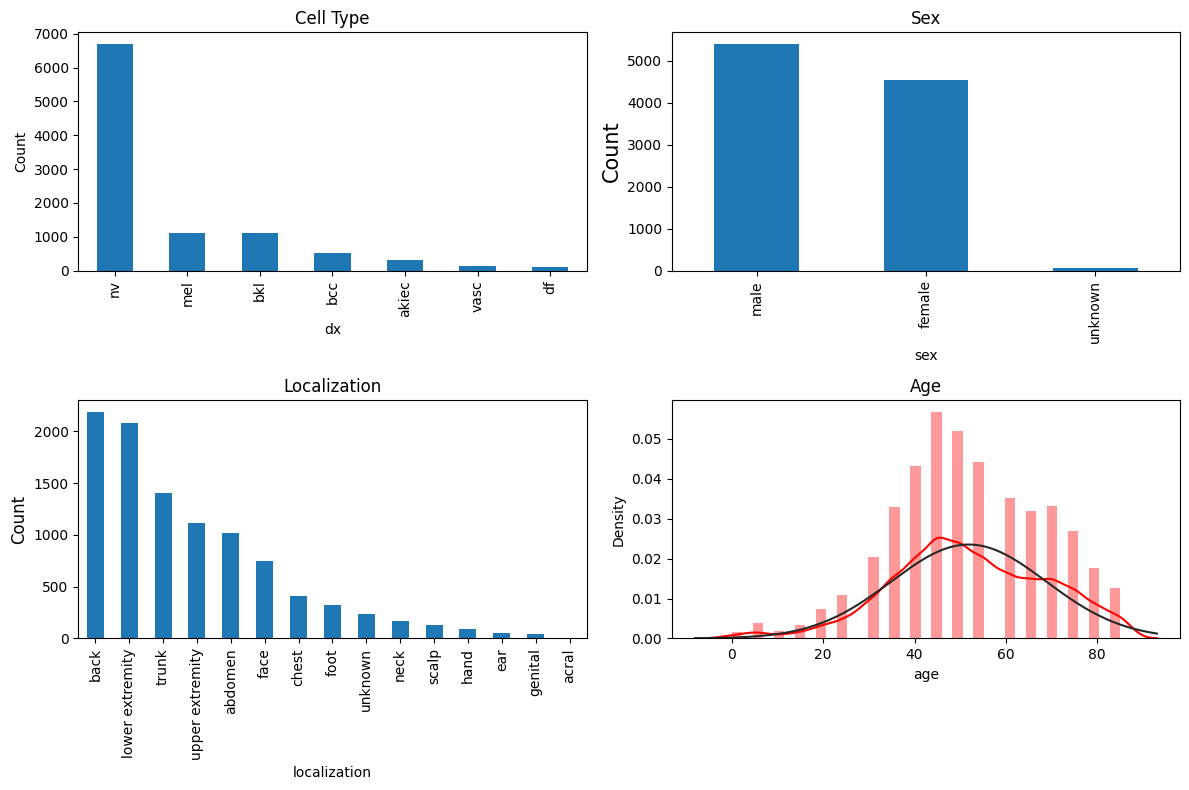

In [5]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [6]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [7]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [8]:
n_samples=400 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [10]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced,df_2_balanced, df_3_balanced,df_4_balanced, df_5_balanced, df_6_balanced])

In [11]:
skin_df_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0


In [12]:
print(skin_df_balanced['label'].value_counts())

label
0    400
1    400
2    400
3    400
4    400
5    400
6    400
Name: count, dtype: int64


In [13]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('*', '*.jpg'))}

In [14]:
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

In [15]:
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

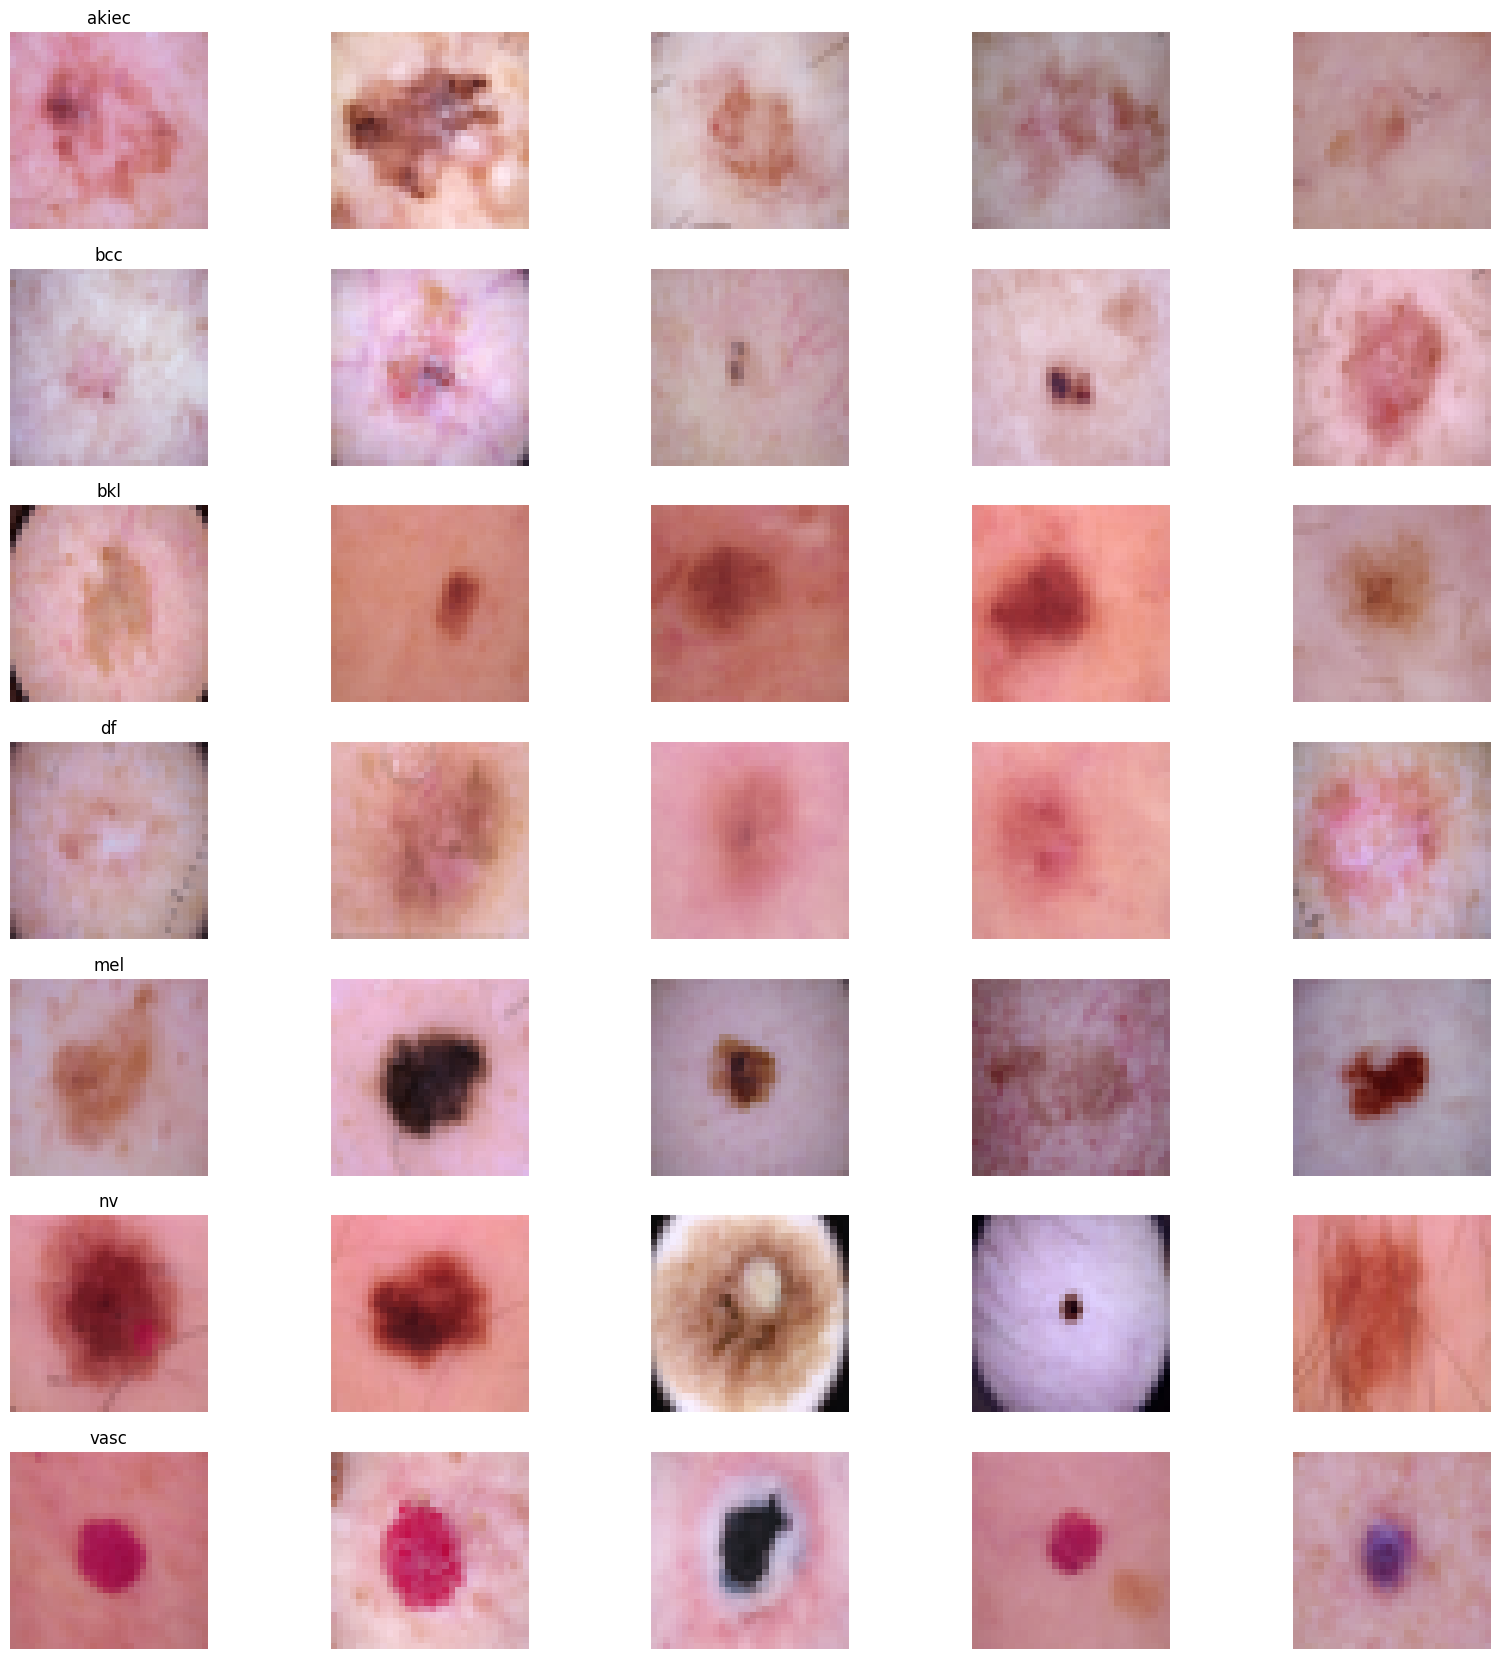

In [16]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [18]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=42)


In [19]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [22]:
batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/50


140/140 - 7s - loss: 1.9403 - acc: 0.1603 - val_loss: 1.8676 - val_acc: 0.2250 - 7s/epoch - 50ms/step
Epoch 2/50
140/140 - 5s - loss: 1.7678 - acc: 0.2607 - val_loss: 1.6824 - val_acc: 0.3214 - 5s/epoch - 38ms/step
Epoch 3/50
140/140 - 5s - loss: 1.5792 - acc: 0.3299 - val_loss: 1.5353 - val_acc: 0.3857 - 5s/epoch - 37ms/step
Epoch 4/50
140/140 - 5s - loss: 1.4873 - acc: 0.3920 - val_loss: 1.6124 - val_acc: 0.3125 - 5s/epoch - 36ms/step
Epoch 5/50
140/140 - 5s - loss: 1.4840 - acc: 0.3942 - val_loss: 1.4060 - val_acc: 0.4554 - 5s/epoch - 37ms/step
Epoch 6/50
140/140 - 6s - loss: 1.3911 - acc: 0.4411 - val_loss: 1.3651 - val_acc: 0.4679 - 6s/epoch - 41ms/step
Epoch 7/50
140/140 - 5s - loss: 1.3654 - acc: 0.4549 - val_loss: 1.3750 - val_acc: 0.4625 - 5s/epoch - 37ms/step
Epoch 8/50
140/140 - 5s - loss: 1.3264 - acc: 0.4821 - val_loss: 1.2854 - val_acc: 0.5071 - 5s/epoch - 37ms/step
Epoch 9/50
140/140 - 5s - loss: 1.2810 - acc: 0.4946 - val_loss: 1.3278 - val_acc: 0.4982 - 5s

In [23]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

18/18 [==============================] - 1s 19ms/step - loss: 0.7766 - acc: 0.7429
Test accuracy: 0.7428571581840515


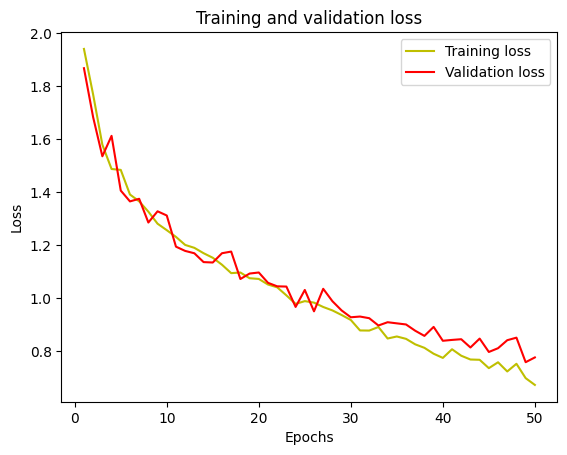

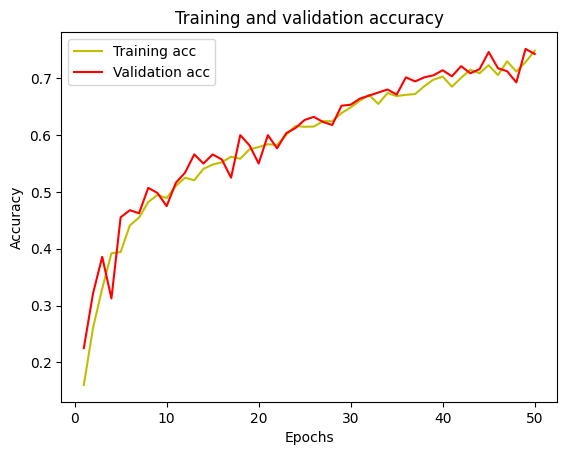

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix

18/18 [==============================] - 0s 20ms/step


Text(45.722222222222214, 0.5, 'Fraction of incorrect predictions')

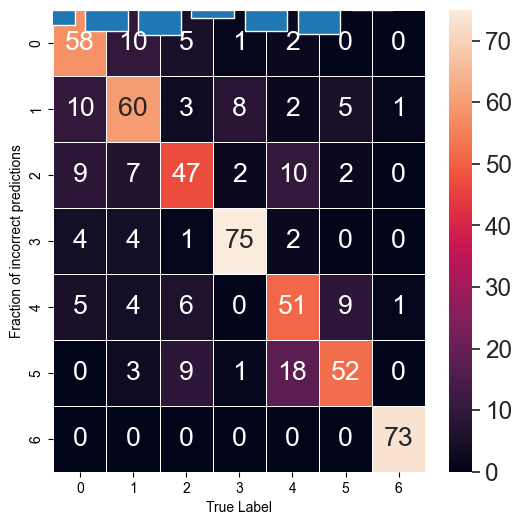

In [27]:
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [28]:
pickle.dump(model, open('model_1.pkl','wb'))